<a href="https://colab.research.google.com/github/anugrahatY/RaspberryPunch/blob/main/BatteryLifeML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install pandas numpy matplotlib scikit-learn joblib

In [2]:
import zipfile, pandas as pd

zip_path = "Experimental_data_aged_cell.csv.zip"
with zipfile.ZipFile(zip_path,'r') as z:

    with z.open("Experimental_data_aged_cell.csv") as f:
        df = pd.read_csv(f)

df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
df['Current'] = pd.to_numeric(df['Current'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
print(df.shape); print(df.columns)


(307513, 4)
Index(['Time', 'Current', 'Voltage', 'Temperature'], dtype='object')


In [3]:
print(df.head())
print(df.describe())
print("sampling interval median (Time diff):", df['Time'].diff().median())
print("proportion positive current:", (df['Current']>0).mean(), "negative:", (df['Current']<0).mean())


       Time   Current   Voltage  Temperature
0  0.000000  2.360728  2.999311    27.449894
1  1.000008  2.303036  2.999813    27.724861
2  2.000008  2.284371  2.999863    27.545357
3  3.000008  2.221588  2.999863    27.457523
4  4.000008  2.158805  2.999813    27.484249
                Time        Current        Voltage    Temperature
count  307513.000000  307513.000000  307513.000000  307513.000000
mean   153756.000008      -0.163968       3.849060      26.320183
std     88771.501002      17.285349       0.206192       0.433726
min         0.000000     -20.152779       2.998059      25.112604
25%     76878.000008     -19.996674       3.726224      25.941347
50%    153756.000008      -4.350225       3.858586      26.372910
75%    230634.000008      19.973799       3.996411      26.640247
max    307512.000008      33.203965       4.208818      28.110600
sampling interval median (Time diff): 1.0
proportion positive current: 0.4641299717410321 negative: 0.5300166171836638


In [4]:
import numpy as np
is_discharge = df['Current'] < 0
changes = is_discharge.astype(int).diff().fillna(0)
starts = changes[changes==1].index.tolist()
ends   = changes[changes==-1].index.tolist()


if len(starts) and len(ends) and ends[0] < starts[0]:
    ends = ends[1:]
if len(starts) > len(ends):
    ends.append(len(df)-1)


min_seconds = 10
cycles = []
for s,e in zip(starts, ends):
    t0, t1 = df.at[s,'Time'], df.at[e,'Time']
    duration = t1 - t0
    if duration < min_seconds: continue
    seg = df.iloc[s:e+1]
    capacity_As = -np.trapz(seg['Current'].values, seg['Time'].values)
    capacity_Ah = capacity_As / 3600.0
    energy_Wh = -np.trapz(seg['Voltage']*seg['Current'], seg['Time'].values)/3600.0
    cycles.append({
        'start_idx': int(s), 'end_idx': int(e),
        'start_time': float(t0), 'end_time': float(t1), 'duration_s': float(duration),
        'capacity_Ah': capacity_Ah, 'energy_Wh': energy_Wh,
        'start_voltage': float(seg['Voltage'].iloc[0]), 'end_voltage': float(seg['Voltage'].iloc[-1])
    })
cycles_df = pd.DataFrame(cycles)
cycles_df.to_csv("cycles_features.csv", index=False)


/tmp/ipython-input-2551771224.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  capacity_As = -np.trapz(seg['Current'].values, seg['Time'].values)
/tmp/ipython-input-2551771224.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_Wh = -np.trapz(seg['Voltage']*seg['Current'], seg['Time'].values)/3600.0


In [5]:
import numpy as np
is_discharge = df['Current'] < 0
changes = is_discharge.astype(int).diff().fillna(0)
starts = changes[changes==1].index.tolist()
ends   = changes[changes==-1].index.tolist()

if len(starts) and len(ends) and ends[0] < starts[0]:
    ends = ends[1:]
if len(starts) > len(ends):
    ends.append(len(df)-1)


min_seconds = 10
cycles = []
for s,e in zip(starts, ends):
    t0, t1 = df.at[s,'Time'], df.at[e,'Time']
    duration = t1 - t0
    if duration < min_seconds: continue
    seg = df.iloc[s:e+1]

    capacity_As = -np.trapz(seg['Current'].values, seg['Time'].values)
    capacity_Ah = capacity_As / 3600.0
    energy_Wh = -np.trapz(seg['Voltage']*seg['Current'], seg['Time'].values)/3600.0
    cycles.append({
        'start_idx': int(s), 'end_idx': int(e),
        'start_time': float(t0), 'end_time': float(t1), 'duration_s': float(duration),
        'capacity_Ah': capacity_Ah, 'energy_Wh': energy_Wh,
        'start_voltage': float(seg['Voltage'].iloc[0]), 'end_voltage': float(seg['Voltage'].iloc[-1])
    })
cycles_df = pd.DataFrame(cycles)
cycles_df.to_csv("cycles_features.csv", index=False)


/tmp/ipython-input-1575730597.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  capacity_As = -np.trapz(seg['Current'].values, seg['Time'].values)
/tmp/ipython-input-1575730597.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_Wh = -np.trapz(seg['Voltage']*seg['Current'], seg['Time'].values)/3600.0


In [6]:
full_cycles = cycles_df[cycles_df['capacity_Ah'] >= 1.0].copy()
# compute SoH% using baseline = max capacity observed among these full cycles
baseline_capacity = full_cycles['capacity_Ah'].max()
full_cycles['SoH_pct'] = full_cycles['capacity_Ah'] / baseline_capacity * 100.0
#SoH should be based on comparable, full discharge capacity numbers not tiny pulses


In [12]:
early_rows = []
min_early_seconds = 2
early_fraction = 0.2  # use first 20% of discharge duration

for idx, (i, row) in enumerate(full_cycles.iterrows()):   # idx = safe counter
    s = int(row['start_idx'])
    e = int(row['end_idx'])
    duration = row['duration_s']

    # Early window duration
    early_dur = max(min_early_seconds, int(duration * early_fraction))
    early_dur = min(early_dur, max(1, int(duration - 1)))

    start_time = row['start_time']
    early_end_time = start_time + early_dur

    seg = df.iloc[s:e+1]
    early_seg = seg[seg['Time'] <= early_end_time]
    if early_seg.empty:
        early_seg = seg.iloc[:1]

    cur = early_seg['Current'].values
    volt = early_seg['Voltage'].values
    temp = early_seg['Temperature'].values
    time = early_seg['Time'].values

    early_capacity_Ah = -np.trapz(cur, time) / 3600.0
    early_energy_Wh   = -np.trapz(volt * cur, time) / 3600.0
    early_avg_voltage = float(np.mean(volt))
    early_voltage_drop = float(volt[0] - volt[-1])
    early_mean_current = float(np.mean(np.abs(cur)))
    early_std_voltage = float(np.std(volt))
    early_mean_temp = float(np.mean(temp))
    early_max_current = float(np.max(np.abs(cur)))

    # Previous cycle SoH
    prev_soh_val = float(full_cycles.iloc[idx-1]['SoH_pct']) if idx > 0 else None

    early_rows.append({
        'cycle_index': idx + 1,  # clean 1-based index
        'early_dur_s': early_dur,
        'early_capacity_Ah': early_capacity_Ah,
        'early_energy_Wh': early_energy_Wh,
        'early_avg_voltage': early_avg_voltage,
        'early_voltage_drop': early_voltage_drop,
        'early_mean_current_A': early_mean_current,
        'early_std_voltage': early_std_voltage,
        'early_mean_temp_C': early_mean_temp,
        'early_max_current_A': early_max_current,
        'prev_cycle_SoH_pct': prev_soh_val,
        'SoH_pct': float(row['SoH_pct'])
    })

early_df = pd.DataFrame(early_rows)

# Fill NaN prev_cycle_SoH_pct
early_df['prev_cycle_SoH_pct'] = early_df['prev_cycle_SoH_pct'].fillna(method='bfill').fillna(early_df['SoH_pct'].iloc[0])

# Save
early_df.to_csv("early_full_cycle_features.csv", index=False)
print("✅ Saved early_full_cycle_features.csv")
display(early_df.head())


✅ Saved early_full_cycle_features.csv


/tmp/ipython-input-264580006.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  early_capacity_Ah = -np.trapz(cur, time) / 3600.0
/tmp/ipython-input-264580006.py:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  early_energy_Wh   = -np.trapz(volt * cur, time) / 3600.0
/tmp/ipython-input-264580006.py:57: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  early_df['prev_cycle_SoH_pct'] = early_df['prev_cycle_SoH_pct'].fillna(method='bfill').fillna(early_df['SoH_pct'].iloc[0])


,cycle_index,early_dur_s,early_capacity_Ah,early_energy_Wh,early_avg_voltage,early_voltage_drop,early_mean_current_A,early_std_voltage,early_mean_temp_C,early_max_current_A,prev_cycle_SoH_pct,SoH_pct
0,1,701,3.896829,14.132714,3.626460,-0.659254,20.012312,0.141633,26.401572,20.100178,99.961244,99.961244
1,2,701,3.896546,14.131713,3.626448,-0.659454,20.010823,0.141624,26.400664,20.132418,99.961244,99.975359
2,3,701,3.897022,14.133094,3.626366,-0.659003,20.013237,0.141644,26.393662,20.123936,99.975359,99.961406
3,4,701,3.897109,14.133165,3.626301,-0.659053,20.013653,0.141651,26.406072,20.110361,99.961406,99.950402
4,5,701,3.896776,14.131817,3.626277,-0.659704,20.011932,0.141643,26.401371,20.122238,99.950402,99.948556


In [13]:
import pandas as pd

# Load the early feature dataset
early_df = pd.read_csv("early_full_cycle_features.csv")

# Define labels from thresholds
def label_soh(soh, t_reduce=90.0, t_replace=80.0):
    if soh >= t_reduce:
        return 0   # healthy
    elif soh >= t_replace:
        return 1   # reduce load
    else:
        return 2   # replace

early_df['class_label'] = early_df['SoH_pct'].apply(label_soh)

print("✅ Added class_label column")
display(early_df.head())


✅ Added class_label column


,cycle_index,early_dur_s,early_capacity_Ah,early_energy_Wh,early_avg_voltage,early_voltage_drop,early_mean_current_A,early_std_voltage,early_mean_temp_C,early_max_current_A,prev_cycle_SoH_pct,SoH_pct,class_label
0,1,701,3.896829,14.132714,3.626460,-0.659254,20.012312,0.141633,26.401572,20.100178,99.961244,99.961244,0
1,2,701,3.896546,14.131713,3.626448,-0.659454,20.010823,0.141624,26.400664,20.132418,99.961244,99.975359,0
2,3,701,3.897022,14.133094,3.626366,-0.659003,20.013237,0.141644,26.393662,20.123936,99.975359,99.961406,0
3,4,701,3.897109,14.133165,3.626301,-0.659053,20.013653,0.141651,26.406072,20.110361,99.961406,99.950402,0
4,5,701,3.896776,14.131817,3.626277,-0.659704,20.011932,0.141643,26.401371,20.122238,99.950402,99.948556,0


In [14]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import math, joblib

# Feature columns (early features only, no leakage)
feature_cols = [
    'early_dur_s','early_capacity_Ah','early_energy_Wh',
    'early_avg_voltage','early_voltage_drop','early_mean_current_A',
    'early_std_voltage','early_mean_temp_C','early_max_current_A',
    'prev_cycle_SoH_pct'
]

X = early_df[feature_cols]
y_reg = early_df['SoH_pct']         # regression target
y_clf = early_df['class_label']     # classification target

# Chronological split
n = len(early_df)
train_end = int(n * 0.7)

X_train, X_test = X.iloc[:train_end], X.iloc[train_end:]
y_reg_train, y_reg_test = y_reg.iloc[:train_end], y_reg.iloc[train_end:]
y_clf_train, y_clf_test = y_clf.iloc[:train_end], y_clf.iloc[train_end:]

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

# --- Regression model ---
rfr = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rfr.fit(X_train, y_reg_train)
y_reg_pred = rfr.predict(X_test)

mae = mean_absolute_error(y_reg_test, y_reg_pred)
rmse = math.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
r2 = r2_score(y_reg_test, y_reg_pred)

print("\n📊 Regression Results:")
print("MAE:", mae, "RMSE:", rmse, "R2:", r2)

# Save model
joblib.dump(rfr, "rfr_soh_model.joblib")

# --- Classification model ---
rfc = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rfc.fit(X_train, y_clf_train)
y_clf_pred = rfc.predict(X_test)

print("\n📊 Classification Results:")
print("Accuracy:", accuracy_score(y_clf_test, y_clf_pred))
print("\nReport:\n", classification_report(y_clf_test, y_clf_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_clf_test, y_clf_pred))

# Save model
joblib.dump(rfc, "rfc_class_model.joblib")

print("\n✅ Models trained and saved: rfr_soh_model.joblib & rfc_class_model.joblib")


Train size: 46 Test size: 21

📊 Regression Results:
MAE: 3.7572461832757758 RMSE: 7.99441259970958 R2: -0.6842885396437943

📊 Classification Results:
Accuracy: 1.0

Report:
               precision    recall  f1-score   support

           2       1.00      1.00      1.00        21

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21


Confusion Matrix:
 [[21]]

✅ Models trained and saved: rfr_soh_model.joblib & rfc_class_model.joblib


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


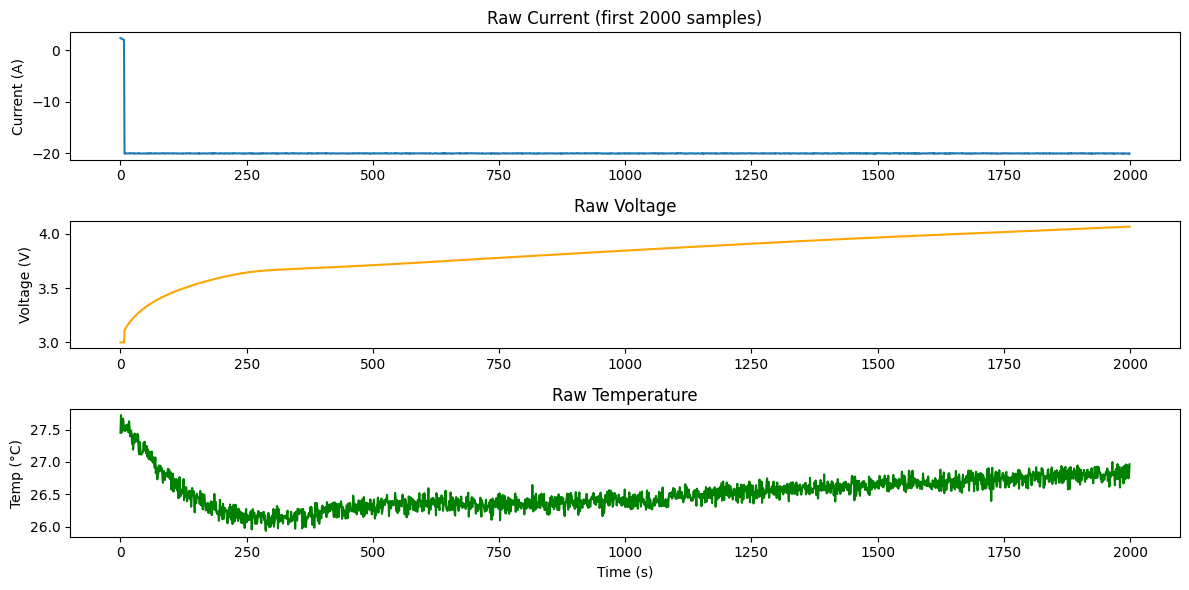

In [15]:
#raw signal inspection (voltage, current, temperature over time) visualisation

import matplotlib.pyplot as plt


sample_window = 2000
plt.figure(figsize=(12,6))

plt.subplot(3,1,1)
plt.plot(df['Time'][:sample_window], df['Current'][:sample_window])
plt.ylabel("Current (A)")
plt.title("Raw Current (first {} samples)".format(sample_window))

plt.subplot(3,1,2)
plt.plot(df['Time'][:sample_window], df['Voltage'][:sample_window], color='orange')
plt.ylabel("Voltage (V)")
plt.title("Raw Voltage")

plt.subplot(3,1,3)
plt.plot(df['Time'][:sample_window], df['Temperature'][:sample_window], color='green')
plt.ylabel("Temp (°C)")
plt.xlabel("Time (s)")
plt.title("Raw Temperature")

plt.tight_layout()
plt.show()


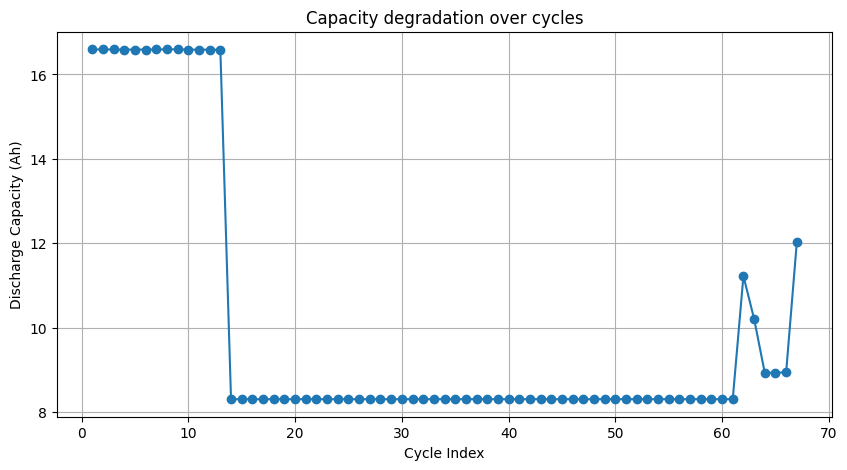

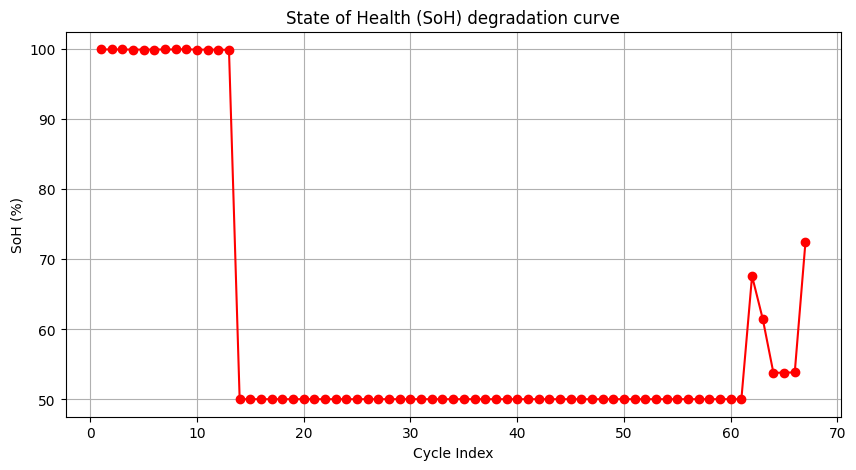

In [17]:
# Add cycle_index manually
full_cycles = full_cycles.reset_index(drop=True)   # reset index to 0..N-1
full_cycles['cycle_index'] = range(1, len(full_cycles) + 1)

# Now plotting will work
plt.figure(figsize=(10,5))
plt.plot(full_cycles['cycle_index'], full_cycles['capacity_Ah'], marker='o')
plt.xlabel("Cycle Index")
plt.ylabel("Discharge Capacity (Ah)")
plt.title("Capacity degradation over cycles")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(full_cycles['cycle_index'], full_cycles['SoH_pct'], marker='o', color='red')
plt.xlabel("Cycle Index")
plt.ylabel("SoH (%)")
plt.title("State of Health (SoH) degradation curve")
plt.grid(True)
plt.show()



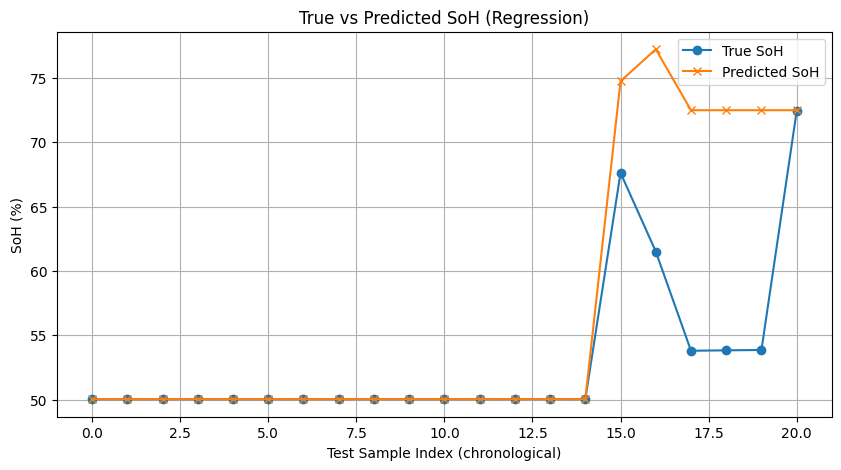

In [18]:
#True vs Predicted SOH (Regression Model Evaluation)

plt.figure(figsize=(10,5))
plt.plot(y_reg_test.values, label="True SoH", marker='o')
plt.plot(y_reg_pred, label="Predicted SoH", marker='x')
plt.xlabel("Test Sample Index (chronological)")
plt.ylabel("SoH (%)")
plt.title("True vs Predicted SoH (Regression)")
plt.legend()
plt.grid(True)
plt.show()


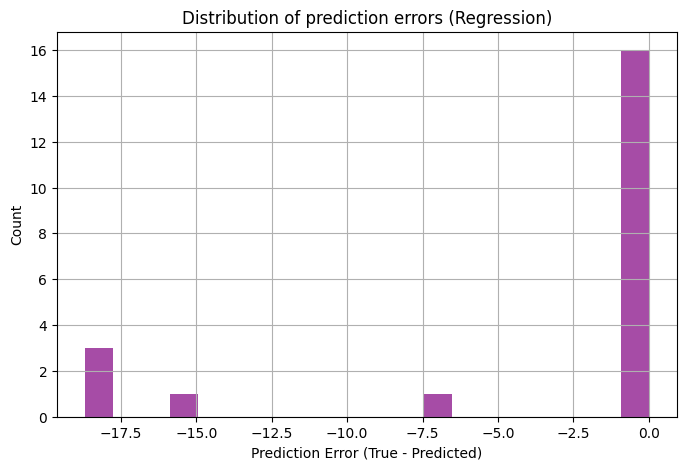

In [19]:
errors = y_reg_test.values - y_reg_pred
plt.figure(figsize=(8,5))
plt.hist(errors, bins=20, color='purple', alpha=0.7)
plt.xlabel("Prediction Error (True - Predicted)")
plt.ylabel("Count")
plt.title("Distribution of prediction errors (Regression)")
plt.grid(True)
plt.show()


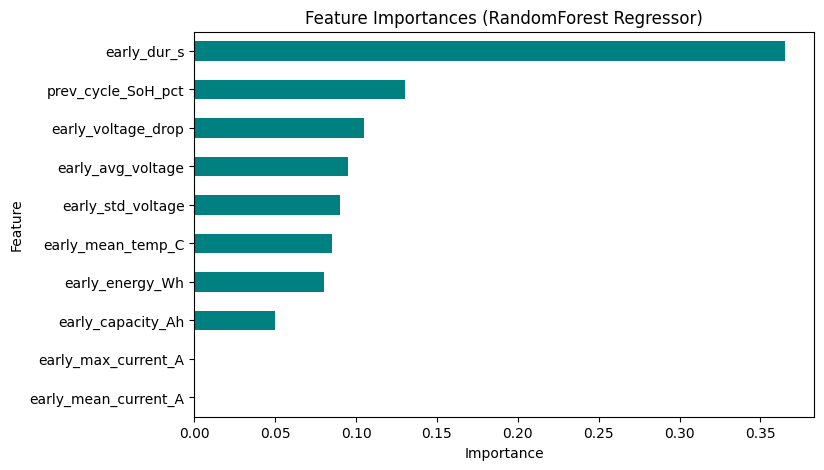

In [20]:
#feature importance (regression model)

importances = pd.Series(rfr.feature_importances_, index=feature_cols).sort_values(ascending=True)

plt.figure(figsize=(8,5))
importances.plot(kind='barh', color='teal')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances (RandomForest Regressor)")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


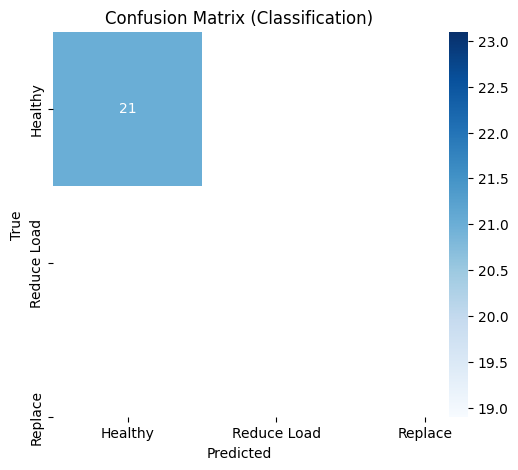

In [21]:
#Confusion Matrix (Classification Model)

import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_clf_test, y_clf_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy","Reduce Load","Replace"],
            yticklabels=["Healthy","Reduce Load","Replace"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Classification)")
plt.show()


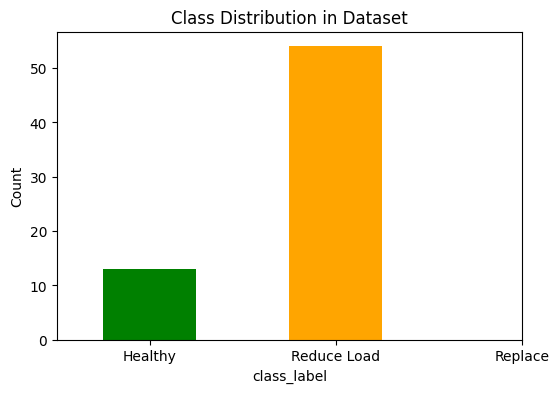

In [22]:
#Class Distribution (Check Balance)
plt.figure(figsize=(6,4))
early_df['class_label'].value_counts().sort_index().plot(kind='bar', color=['green','orange','red'])
plt.xticks([0,1,2], ["Healthy","Reduce Load","Replace"], rotation=0)
plt.ylabel("Count")
plt.title("Class Distribution in Dataset")
plt.show()


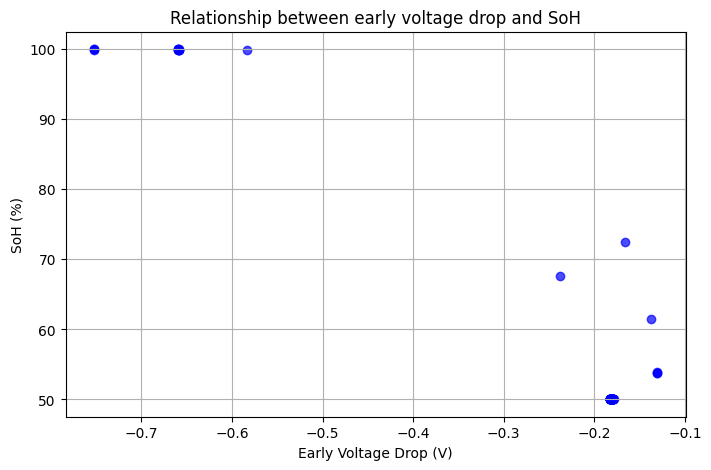

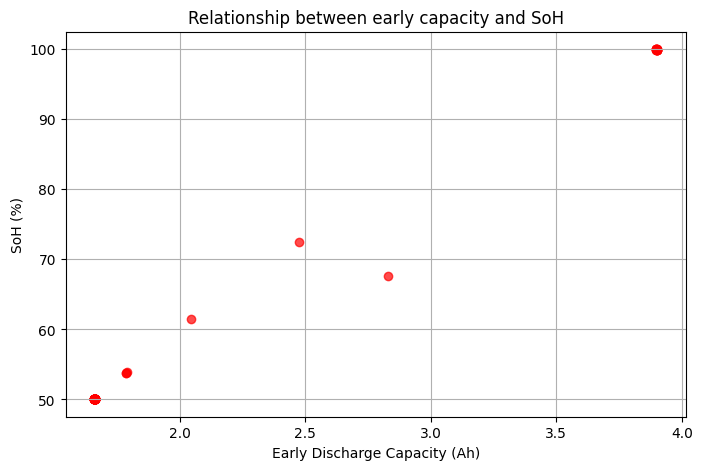

In [23]:
#SoH vs Early Features

plt.figure(figsize=(8,5))
plt.scatter(early_df['early_voltage_drop'], early_df['SoH_pct'], alpha=0.7, c='blue')
plt.xlabel("Early Voltage Drop (V)")
plt.ylabel("SoH (%)")
plt.title("Relationship between early voltage drop and SoH")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(early_df['early_capacity_Ah'], early_df['SoH_pct'], alpha=0.7, c='red')
plt.xlabel("Early Discharge Capacity (Ah)")
plt.ylabel("SoH (%)")
plt.title("Relationship between early capacity and SoH")
plt.grid(True)
plt.show()


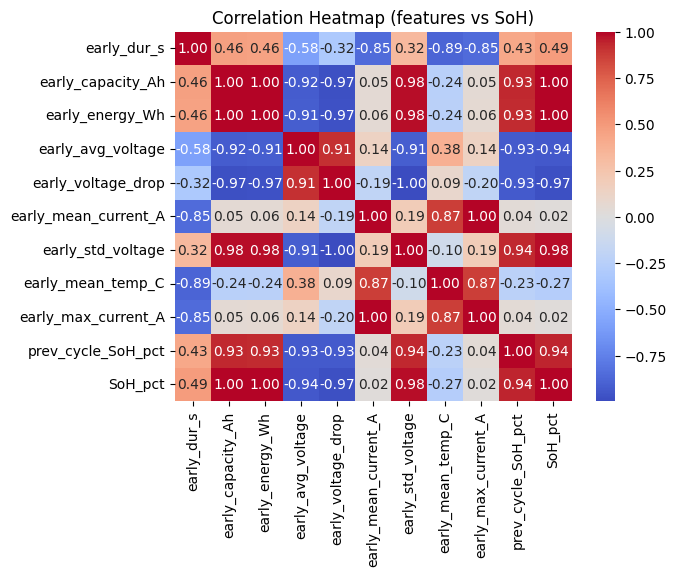

In [24]:
#SoH degradation heatmap

sns.heatmap(early_df[feature_cols + ['SoH_pct']].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (features vs SoH)")
plt.show()
